In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import os
import re
import logging
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from statsmodels.graphics.mosaicplot import mosaic

DATA_READY = True

%matplotlib inline

In [2]:
'''
Logging Configuration
'''

logs_dir = "./logs"

log_filepath = os.path.join(logs_dir, 'df_wrd_error.log')

logging.basicConfig(filename=log_filepath, filemode='w', format='%(levelname)s - %(message)s')

In [3]:
DEBUG = False
INFO = False
TEST = True

<a id='toc'></a>

# Table of Contents
---

* [I. Gathering](#gathering)
* [II. Assessing](#assessing)
* [III. Cleaning](#cleaning)
* [IV. Analyzing & Visualizing](#av)

<a id='gathering'></a>
# I. Gathering Data 
---

In [4]:
data_dir = "./data"

### a. WeRateDogs Twitter Archive

In [5]:
wrd_data_filepath = 'twitter-archive-enhanced.csv'

df_wrd_twitter_old = pd.read_csv(os.path.join(data_dir, wrd_data_filepath))

### b. Tweet Image Predictions

In [6]:
image_predictions_filepath = os.path.join(data_dir, 'image-predictions.tsv')

In [7]:
if not DATA_READY:

    url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

    response = requests.get(url, allow_redirects=True)

    with open(image_predictions_filepath, 'wb') as f:
        f.write(response.content)

In [8]:
df_image_predictions_old = pd.read_csv(image_predictions_filepath, sep="\t")

### c. Any Additional Data

**Via Twitter API**

In [9]:
json_filepath = os.path.join(data_dir, "tweet_json.txt")

In [10]:
if not DATA_READY:

    with open('twitter-credential.json') as f:
        credentials = json.load(f)

    auth = tweepy.OAuthHandler(credentials['consumer_key'], credentials['consumer_secret'])

    auth.set_access_token(credentials['access_token'], credentials['access_token_secret'])

    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

    tweet_ids = df_wrd_twitter_old['tweet_id']

    statuses = []

    for tweet_id in tqdm(tweet_ids):

        try:

            status = api.get_status(tweet_id, tweet_mode='extended')

            statuses.append(status._json)

        except:

            continue

    with open(json_filepath, 'w') as outfile:
        for status in statuses:
            json.dump(status, outfile)
            outfile.write("\n")

In [11]:
df_tweet_json_old = pd.read_json(json_filepath, lines=True)

**Via Kaggle** [For all available dog breeds]

Reference: 
    [https://www.kaggle.com/c/dog-breed-identification/data](https://www.kaggle.com/c/dog-breed-identification/data)

In [12]:
df_dog_breeds_old = pd.read_csv(os.path.join(data_dir, "labels.csv"))

<a id='assessing'></a>
# II. Assessing Data
---

In [13]:
'''
Uncomment to view data
'''

# df_wrd_twitter_old

'\nUncomment to view data\n'

> **Summary**
> * name, doggo, floofer, pupper and puppo columns contain "None"
> * name contains "a" as a value. May contain other nonsense name
> * tweet information and dog information in the same table
> * name (refers to dog name) is not very descriptive since tweet information and dog information are in the same table
> * text (refers to status update) is not very descriptive since tweet information and dog information are in the same table

In [14]:
'''
Uncomment to view data
'''

# df_image_predictions_old

'\nUncomment to view data\n'

> **Summary**
> * img_num, p1, p1_conf, p1_dog, etc. are not very descriptive
> * Values of p1, p2, p3 have formatting issues. Some starts with uppercase characters, but others start with lowercase characters

In [15]:
'''
Uncomment to view data
'''

# df_tweet_json_old

'\nUncomment to view data\n'

> **Summary**
> * For each type of id, there are two columns for it for the same piece of information except that their data types are different

In [16]:
'''
Uncomment to view data
'''

# df_dog_breeds_old

'\nUncomment to view data\n'

In [17]:
df_wrd_twitter_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

> **Summary**
> * All ids(tweet_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id)
 have numeric data type instead of string
> * timestamp is of string type
> * Even though some columns have null values, it is reasonable
> * doggo, floofer, pupper and puppo can be combined into a single column
> * Columns may be ignored: 
>   in_reply_to_status_id, in_reply_to_user_id, source, expanded_urls

In [18]:
df_image_predictions_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


> **Summary**
> * The data type of tweet_id is integer
> * No missing values in this table

In [19]:
df_tweet_json_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2331 non-null   datetime64[ns, UTC]
 1   id                             2331 non-null   int64              
 2   id_str                         2331 non-null   int64              
 3   full_text                      2331 non-null   object             
 4   truncated                      2331 non-null   bool               
 5   display_text_range             2331 non-null   object             
 6   entities                       2331 non-null   object             
 7   extended_entities              2059 non-null   object             
 8   source                         2331 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

> **Summary**
> * Columns may be ignored: 
>   * created_at, truncated, in_reply_to_user_id, in_reply_to_status_id_str, in_reply_to_user_id
>   * in_reply_to_user_id_str, in_reply_to_screen_name, is_quote_status, possibly_sensitive
>   * possibly_sensitive_appealable, lang, quoted_status_id, quoted_status_id_str, quoted_status_permalink
>   * quoted_status, geo, coordinates, place
> * id is of numeric type

In [20]:
df_dog_breeds_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


#### ****************************** Further Investigation On Data  ******************************

In [21]:
df_wrd_twitter_old.duplicated(['tweet_id']).sum()

0

In [22]:
df_wrd_twitter_old.duplicated(['name']).sum()

1399

In [23]:
if INFO:
    print(df_wrd_twitter_old['name'].value_counts().to_dict())

> **Summary**
> * Have invalid names other than 'None', eg: a, an, the, one. All starts with lowercase characters.
> * Name column has duplicated entries

In [24]:
p = re.compile('[0-9]+/10')
p_invalid = re.compile('[0-9]+/[0-9]+/[0-9]+')

bad_count = 0
none_count = 0
good_count = 0


for text, denominator, numerator in zip(df_wrd_twitter_old['text'].values, df_wrd_twitter_old['rating_denominator'].values, df_wrd_twitter_old['rating_numerator'].values):
    result = p.search(text)
    if result is not None and denominator != 10: # when denominators and numerators are wrong
        if INFO:
            message = "{} {} {} ************************ {}".format(result.group(), numerator, denominator, text)
            logging.error(message)
            logging.error("\n")
        bad_count += 1
    elif result is None and p_invalid.search(text) == None:
#         print(numerator, denominator, "~~~~~~~~~~~~~~~~~~~~~~~", text)
#         print()
        none_count += 1
    elif result is not None and denominator == 10:
        good_count += 1
    elif p_invalid.search(text) != None: # when parsing date as ratings
        if INFO:
            message = "{} {} ************************ {}".format(numerator, denominator, text)
            logging.error(message)
            logging.error("\n")

print("Number of true positive ratings: ", good_count)
print("Number of wrong ratings: ", bad_count)
print("Please check for logs for wrong ratings")

Number of true positive ratings:  2333
Number of wrong ratings:  7
Please check for logs for wrong ratings


In [25]:
text_to_remove = []

for text, denominator, numerator in zip(
    df_wrd_twitter_old['text'].values, 
    df_wrd_twitter_old['rating_denominator'].values, 
    df_wrd_twitter_old['rating_numerator'].values):
    
    result = p.search(text)
    
    if result is not None and denominator != 10:
        text_to_remove.append(text)
        
df_wrd_twitter_old[df_wrd_twitter_old.text.isin(text_to_remove)][
    ['text', 'rating_denominator', 'rating_numerator']]

,text,rating_denominator,rating_numerator
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,0,960
784,"RT @dog_rates: After so many requests, this is...",11,9
1068,"After so many requests, this is Bretagne. She ...",11,9
1165,Happy 4/20 from the squad! 13/10 for all https...,20,4
1202,This is Bluebert. He just saw that both #Final...,50,50
1662,This is Darrel. He just robbed a 7/11 and is i...,11,7
2335,This is an Albanian 3 1/2 legged Episcopalian...,2,1


> **Summary**
> * There are 7 rows in df_wrd_twitter_old with wrong denominators and numerators
> * There is 2 rows parsing time as ratings: 1) 24/7 2) 11/15/15

In [26]:
df_wrd_twitter_old.isin(["None"]).sum()

tweet_id                         0
in_reply_to_status_id            0
in_reply_to_user_id              0
timestamp                        0
source                           0
text                             0
retweeted_status_id              0
retweeted_status_user_id         0
retweeted_status_timestamp       0
expanded_urls                    0
rating_numerator                 0
rating_denominator               0
name                           745
doggo                         2259
floofer                       2346
pupper                        2099
puppo                         2326
dtype: int64

> **Summary**
> * name, doggo, pupper, puppo and floofer have "None" values as expected

In [27]:
df_image_predictions_old.duplicated().sum()

0

In [28]:
# df_tweet_json_old.duplicated().sum()

'''
Have TypeError after executing the above statement
- TypeError: unhashable type: 'list'
'''

"\nHave TypeError after executing the above statement\n- TypeError: unhashable type: 'list'\n"

In [29]:
df_dog_breeds_old.duplicated(['breed']).sum()

10102

In [30]:
if INFO:
    print(df_dog_breeds_old['breed'].unique())

> **Summary**
> * There are duplicates under the breed column of df_dog_breeds
> * Formatting issues: both "-" and "_" are used for separaters

<a id='cleaning'></a>
# III. Cleaning Data 
---

In [31]:
df_wrd_twitter = df_wrd_twitter_old.copy()

In [32]:
df_image_predictions = df_image_predictions_old.copy()

In [33]:
df_tweet_json = df_tweet_json_old.copy()

In [34]:
df_dog_breeds = df_dog_breeds_old.copy()

---
---
---

<a id='dbl'></a>

### Dog Breed Label

> Find out rows that are duplicated, get their indices and remove by row indices

In [35]:
duplicated_row_indices = df_dog_breeds[df_dog_breeds.duplicated(['breed'])].index

if DEBUG:
    print(duplicated_row_indices.size)

In [36]:
df_dog_breeds.drop(duplicated_row_indices, inplace=True)

In [37]:
if DEBUG:
    print(duplicated_row_indices.size)

> Fix formatting issues in the breed column

In [38]:
if DEBUG:
    print(df_dog_breeds['breed'].unique())

In [39]:
df_dog_breeds['breed'] = df_dog_breeds['breed'].str.replace("-", "_")

In [40]:
if DEBUG:
    print(df_dog_breeds['breed'].unique())

---
<a id='eta'></a>

### Enhanced Twitter Archive

> Filter out retweets by removing the ones with retweeted_status_id

In [41]:
indices_with_retweets = df_wrd_twitter[df_wrd_twitter['retweeted_status_id'].notnull()].index

df_wrd_twitter.drop(indices_with_retweets, inplace=True)

In [42]:
if DEBUG:
    print(df_wrd_twitter['retweeted_status_id'].unique())

> Drop unnessary columns

In [43]:
unnecessary_columns = [
    'in_reply_to_status_id', 
    'in_reply_to_user_id',
    'source',
    'retweeted_status_id',
    'retweeted_status_user_id',
    'retweeted_status_timestamp',
    'expanded_urls']

df_wrd_twitter.drop(unnecessary_columns, inplace=True, axis=1)

In [44]:
if DEBUG:
    print(df_wrd_twitter.info())

> Update and Remove rows with inaccurate ratings
> * Get all texts where denominator and numerator are wrong
> * Get all rows in the dataframe by matching texts
> * Remove these rows in the dataframe by indices

In [45]:
ratings_to_update = []
ratings_to_remove = []

for text, denominator, numerator in zip(
    df_wrd_twitter['text'].values, 
    df_wrd_twitter['rating_denominator'].values, 
    df_wrd_twitter['rating_numerator'].values):
    
    result = p.search(text)
    
    if result is not None and denominator != 10:
        ratings_to_update.append(text)
    elif text.find('24/7') != -1 or text.find('11/15/15') != -1:
        ratings_to_remove.append(text)
        
if DEBUG:
    print("# of rows to update ratings: ", len(ratings_to_update))
    print("# of rows to remove: ", len(ratings_to_remove))

In [46]:
df_wrd_twitter['text'].duplicated().sum()

0

In [47]:
for text, denominator, numerator in zip(
    df_wrd_twitter['text'].values, 
    df_wrd_twitter['rating_denominator'].values, 
    df_wrd_twitter['rating_numerator'].values):
    
    result = p.search(text)
    
    if result is not None and denominator != 10:
        
        # since text is unique
        index = df_wrd_twitter[df_wrd_twitter['text'] == text].index[0]
        
        ratings = result.group(0).split("/")
        
        df_wrd_twitter.at[index, 'rating_denominator'] = 10
        df_wrd_twitter.at[index, 'rating_numerator'] = ratings[0]

In [48]:
indices_with_wrong_ratings = df_wrd_twitter[df_wrd_twitter.text.isin(ratings_to_remove)].index

df_wrd_twitter.drop(indices_with_wrong_ratings, inplace=True)

In [49]:
if DEBUG:
    
    ratings_to_update = []
    ratings_to_remove = []

    for text, denominator, numerator in zip(
        df_wrd_twitter['text'].values, 
        df_wrd_twitter['rating_denominator'].values, 
        df_wrd_twitter['rating_numerator'].values):

        result = p.search(text)

        if result is not None and denominator != 10:
            ratings_to_update.append(text)
        elif text.find('24/7') != -1 or text.find('11/15/15') != -1:
            ratings_to_remove.append(text)

    print("# of rows to update ratings: ", len(ratings_to_update))
    print("# of rows to remove: ", len(ratings_to_remove))

> Change data types
> * Change data type of tweet_id to object(string) using `.astype(str)`
> * Change data type of timestamp to timestamp using `pd.to_datetime` and `utc=True`
> * Filter out tweets beyond August 1st, 2017
>    * Create a new dataframe with shape(the number of rows in df_wrd_twitter, 1). 
>    * Fill it with value = '2017-08-01'
>    * Convert both series using code like `pd.to_datetime(time_df['timestamp'], utc=True)`
>    * Compare these two series, get the rows with timestamp higher than 2017-08-01, remove by row indices

In [50]:
if DEBUG:
    print(df_wrd_twitter['tweet_id'].dtype, df_wrd_twitter['timestamp'].dtype)

In [51]:
df_wrd_twitter['tweet_id'] = df_wrd_twitter['tweet_id'].astype(str)

In [52]:
df_wrd_twitter['timestamp'] = pd.to_datetime(df_wrd_twitter['timestamp'], utc=True)

In [53]:
col_names =  []

time_df  = pd.DataFrame(columns = col_names)
time_df

time_df['timestamp'] = df_wrd_twitter['timestamp']

time_df['timestamp'] = "2017-08-01"

s = pd.to_datetime(df_wrd_twitter['timestamp'], utc=True)
s1 = pd.to_datetime(time_df['timestamp'], utc=True)

In [54]:
(s > s1).sum()

2

In [55]:
row_indices_to_remove = df_wrd_twitter[(s > s1)].index

df_wrd_twitter.drop(row_indices_to_remove, inplace=True)

In [56]:
if DEBUG:
    print(df_wrd_twitter['tweet_id'].dtype, df_wrd_twitter['timestamp'].dtype)

> Rename columns using `df.rename`
> * name -> dog_name
> * text -> status_update

In [57]:
columns = {
    'text': 'status_update', 
    'name': 'dog_name'
}

df_wrd_twitter.rename(columns=columns, inplace=True)

In [58]:
if DEBUG:
    print(df_wrd_twitter.info())

> Change all invalid names to None not "None" 
> * Find rows containing invalid names: "None" and words starting with lowercase characters
> * Delete rows using row indices

In [59]:
if DEBUG:
    print(df_wrd_twitter.query("dog_name.str.islower() or dog_name == 'None'").index.size)

In [60]:
indices_with_invalid_names = df_wrd_twitter.query("dog_name.str.islower() or dog_name == 'None'").index

df_wrd_twitter.drop(indices_with_invalid_names, inplace=True)

In [61]:
if DEBUG:
    print(df_wrd_twitter.query("dog_name.str.islower() or dog_name == 'None'").index.size)

> * Combine four dog "states" into a single column
>  * Find out indices of row with a specific dog state eg. 'doggo'
>  * Set the "dog_state" of these rows to a value which represents this dog state
>  * Same actions for all states
> * Remove doggo, floofer, pupper, puppo columns

In [62]:
df_wrd_twitter.loc[df_wrd_twitter.query('doggo == "doggo"').index, 'dog_state'] = "doggo"
df_wrd_twitter.loc[df_wrd_twitter.query('floofer == "floofer"').index, 'dog_state'] = "floofer"
df_wrd_twitter.loc[df_wrd_twitter.query('pupper == "pupper"').index, 'dog_state'] = "pupper"
df_wrd_twitter.loc[df_wrd_twitter.query('puppo == "puppo"').index, 'dog_state'] = "puppo"

In [63]:
columns_to_remove = ['doggo', 'floofer', 'pupper', 'puppo']

df_wrd_twitter.drop(columns_to_remove, axis=1, inplace=True)

In [64]:
df_wrd_twitter.query("dog_state == 'puppo'").head()

,tweet_id,timestamp,status_update,rating_numerator,rating_denominator,dog_name,dog_state
14,889531135344209921,2017-07-24 17:02:04+00:00,This is Stuart. He's sporting his favorite fan...,13,10,Stuart,puppo
71,878776093423087618,2017-06-25 00:45:22+00:00,This is Snoopy. He's a proud #PrideMonthPuppo....,13,10,Snoopy,puppo
94,874012996292530176,2017-06-11 21:18:31+00:00,This is Sebastian. He can't see all the colors...,13,10,Sebastian,puppo
129,867421006826221569,2017-05-24 16:44:18+00:00,This is Shikha. She just watched you drop a sk...,12,10,Shikha,puppo
398,825026590719483904,2017-01-27 17:04:02+00:00,Say hello to Pablo. He's one gorgeous puppo. A...,12,10,Pablo,puppo


> * Calculate ratings by dividing rating_numerator by rating_denominator and set values of ratings into new column
> * Remove rating_numerator and rating_denominator columns

In [65]:
df_wrd_twitter['ratings'] = df_wrd_twitter['rating_numerator']/df_wrd_twitter['rating_denominator']

columns_to_remove = ['rating_numerator', 'rating_denominator']

df_wrd_twitter.drop(columns_to_remove, axis=1, inplace=True)

In [66]:
df_wrd_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1388 entries, 2 to 2325
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   tweet_id       1388 non-null   object             
 1   timestamp      1388 non-null   datetime64[ns, UTC]
 2   status_update  1388 non-null   object             
 3   dog_name       1388 non-null   object             
 4   dog_state      184 non-null    object             
 5   ratings        1388 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(4)
memory usage: 115.9+ KB


---
<a id='ipf'></a>

### Image Predictions File

> Change data type of tweet_id to object

In [67]:
if DEBUG:
    print(df_image_predictions['tweet_id'].dtype)

In [68]:
df_image_predictions['tweet_id'] = df_image_predictions['tweet_id'].astype(str)

In [69]:
if DEBUG:
    print(df_image_predictions['tweet_id'].dtype)

> Fix formatting issues of p1, p2 and p3. Final format: starts with lowercase characters and seperated by "_"

In [70]:
df_image_predictions['p1'] = df_image_predictions['p1'].str.lower()
df_image_predictions['p1'] = df_image_predictions['p1'].str.replace("-", "_")

In [71]:
df_image_predictions['p2'] = df_image_predictions['p2'].str.lower()
df_image_predictions['p2'] = df_image_predictions['p2'].str.replace("-", "_")

In [72]:
df_image_predictions['p3'] = df_image_predictions['p3'].str.lower()
df_image_predictions['p3'] = df_image_predictions['p3'].str.replace("-", "_")

In [73]:
if DEBUG:
    print(df_image_predictions['p1'].unique())

> For rows where either p1_dog, p2_dog or p3_dog is true, but predictions do not belong to dog breeds
> * Remove these rows

In [74]:
if DEBUG:
    
    error_count_1 = df_image_predictions[~df_image_predictions.p1.isin(df_dog_breeds['breed'])]['p1_dog'].sum()
    error_count_2 = df_image_predictions[~df_image_predictions.p2.isin(df_dog_breeds['breed'])]['p2_dog'].sum()
    error_count_3 = df_image_predictions[~df_image_predictions.p3.isin(df_dog_breeds['breed'])]['p3_dog'].sum()

    print(error_count_1, error_count_2, error_count_3)

In [75]:
p1_indices_to_remove = \
    df_image_predictions[~df_image_predictions.p1.isin(df_dog_breeds['breed'])].query("p1_dog == True").index
df_image_predictions.drop(p1_indices_to_remove, inplace=True)
    
p2_indices_to_remove = \
    df_image_predictions[~df_image_predictions.p2.isin(df_dog_breeds['breed'])].query("p2_dog == True").index
df_image_predictions.drop(p2_indices_to_remove, inplace=True)
    
p3_indices_to_remove = \
    df_image_predictions[~df_image_predictions.p3.isin(df_dog_breeds['breed'])].query("p3_dog == True").index
df_image_predictions.drop(p3_indices_to_remove, inplace=True)

In [76]:
if DEBUG:
    
    error_count_1 = df_image_predictions[~df_image_predictions.p1.isin(df_dog_breeds['breed'])]['p1_dog'].sum()
    error_count_2 = df_image_predictions[~df_image_predictions.p2.isin(df_dog_breeds['breed'])]['p2_dog'].sum()
    error_count_3 = df_image_predictions[~df_image_predictions.p3.isin(df_dog_breeds['breed'])]['p3_dog'].sum()

    print(error_count_1, error_count_2, error_count_3)

> Rename p1, p2, p3, p1_conf, p2_conf, p3_conf, p1_dog, p2_dog, p3_dog

In [77]:
if DEBUG:
    print(df_image_predictions.columns)

In [78]:
column_map = {
    'p1': 'prediction_1',
    'p1_conf': 'prediction_1_confidence',
    'p1_dog': 'is_prediction_1_dog_breed',
    'p2': 'prediction_2',
    'p2_conf': 'prediction_2_confidence',
    'p2_dog': 'is_prediction_2_dog_breed',
    'p3': 'prediction_3',
    'p3_conf': 'prediction_3_confidence',
    'p3_dog': 'is_prediction_3_dog_breed'
}

df_image_predictions.rename(columns=column_map, inplace=True)

In [79]:
if DEBUG:
    print(df_image_predictions.columns)

In [80]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2053 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tweet_id                   2053 non-null   object 
 1   jpg_url                    2053 non-null   object 
 2   img_num                    2053 non-null   int64  
 3   prediction_1               2053 non-null   object 
 4   prediction_1_confidence    2053 non-null   float64
 5   is_prediction_1_dog_breed  2053 non-null   bool   
 6   prediction_2               2053 non-null   object 
 7   prediction_2_confidence    2053 non-null   float64
 8   is_prediction_2_dog_breed  2053 non-null   bool   
 9   prediction_3               2053 non-null   object 
 10  prediction_3_confidence    2053 non-null   float64
 11  is_prediction_3_dog_breed  2053 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 166.4+ KB


---
<a id='adta'></a>

### Additional Data via the Twitter API

> * Drop unnecessary columns
> * Change the data type of id to string

In [81]:
unnecessary_columns = [
    'created_at', 
    'id_str',
    'full_text',
    'truncated',
    'display_text_range',
    'entities',
    'extended_entities',
    'source',
    'in_reply_to_status_id',
    'in_reply_to_status_id_str',
    'in_reply_to_user_id',
    'in_reply_to_user_id_str',
    'in_reply_to_screen_name',
    'user',
    'geo',
    'coordinates',
    'place',
    'contributors',
    'is_quote_status',
    'possibly_sensitive',
    'possibly_sensitive_appealable',
    'lang',
    'quoted_status_id',
    'quoted_status_id_str',
    'quoted_status_permalink',
    'quoted_status']

df_tweet_json.drop(unnecessary_columns, inplace=True, axis=1)

In [82]:
df_tweet_json['id'] = df_tweet_json['id'].astype(str)

In [83]:
column_map = {'id':'tweet_id'}

df_tweet_json.rename(columns=column_map, inplace=True)

> Filter out retweets by removing rows with non-null retweeted_status

In [84]:
df_tweet_json.drop(df_tweet_json[df_tweet_json['retweeted_status'].notnull()].index, inplace=True)

In [85]:
df_tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 0 to 2330
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2168 non-null   object
 1   retweet_count     2168 non-null   int64 
 2   favorite_count    2168 non-null   int64 
 3   favorited         2168 non-null   bool  
 4   retweeted         2168 non-null   bool  
 5   retweeted_status  0 non-null      object
dtypes: bool(2), int64(2), object(2)
memory usage: 88.9+ KB


---
---

## Finalize
> * Join all tables on tweet_id
> * Replace missing values in dog_state with value 0

In [86]:
df_twitter_archive_master = df_wrd_twitter.copy()

In [87]:
if DEBUG:
    print(df_twitter_archive_master.info())

In [88]:
df_twitter_archive_master = \
    df_twitter_archive_master.set_index('tweet_id').join(df_image_predictions.set_index('tweet_id'), how='inner')

In [89]:
df_twitter_archive_master.loc[df_twitter_archive_master.query('dog_state.isnull()').index, 'dog_state'] = ""

In [90]:
df_twitter_archive_master = \
    df_twitter_archive_master.join(df_tweet_json.set_index('tweet_id'), how='inner')

In [91]:
df_twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1331 entries, 891815181378084864 to 666418789513326592
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   timestamp                  1331 non-null   datetime64[ns, UTC]
 1   status_update              1331 non-null   object             
 2   dog_name                   1331 non-null   object             
 3   dog_state                  1331 non-null   object             
 4   ratings                    1331 non-null   float64            
 5   jpg_url                    1331 non-null   object             
 6   img_num                    1331 non-null   int64              
 7   prediction_1               1331 non-null   object             
 8   prediction_1_confidence    1331 non-null   float64            
 9   is_prediction_1_dog_breed  1331 non-null   bool               
 10  prediction_2               1331 non-null   obj

In [92]:
df_twitter_archive_master.reset_index(inplace = True) 

In [93]:
output_dir = "./output"

output_csv_filepath = os.path.join(output_dir, "twitter_archive_master.csv")

In [94]:
df_twitter_archive_master.to_csv (output_csv_filepath, index = True, header = True)

<a id='av'></a>
# IV. Analyzing & Visualizing Data 
---

In [95]:
data_dir = "./output"

tam_data_filepath = os.path.join(data_dir, "twitter_archive_master.csv") 

In [96]:
df_tam = pd.read_csv(tam_data_filepath, index_col=0)

df_tam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1331 entries, 0 to 1330
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tweet_id                   1331 non-null   int64  
 1   timestamp                  1331 non-null   object 
 2   status_update              1331 non-null   object 
 3   dog_name                   1331 non-null   object 
 4   dog_state                  174 non-null    object 
 5   ratings                    1331 non-null   float64
 6   jpg_url                    1331 non-null   object 
 7   img_num                    1331 non-null   int64  
 8   prediction_1               1331 non-null   object 
 9   prediction_1_confidence    1331 non-null   float64
 10  is_prediction_1_dog_breed  1331 non-null   bool   
 11  prediction_2               1331 non-null   object 
 12  prediction_2_confidence    1331 non-null   float64
 13  is_prediction_2_dog_breed  1331 non-null   bool 

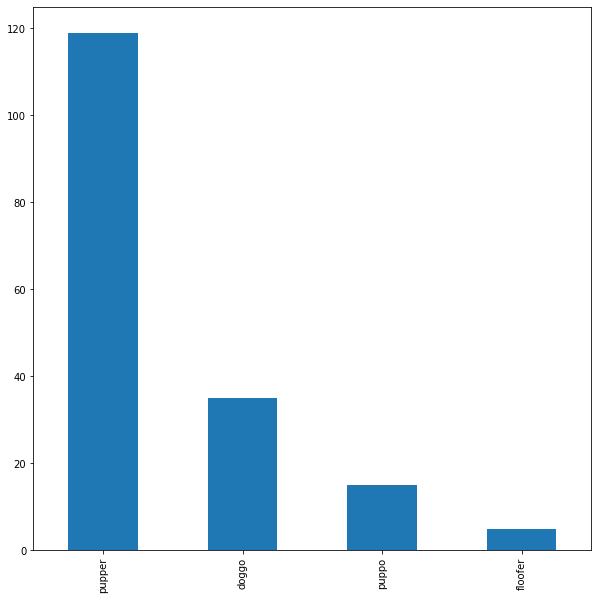

In [97]:
df_tam['dog_state'].value_counts().plot(kind='bar', figsize=(10, 10))

(<Figure size 720x720 with 3 Axes>,
 OrderedDict([(('doggo', 'True'),
               (0.0, 0.0, 0.19817677368212444, 0.7973421926910299)),
              (('doggo', 'False'),
               (0.0,
                0.8006644518272424,
                0.19817677368212444,
                0.19933554817275742)),
              (('puppo', 'True'),
               (0.20310288205650867,
                0.0,
                0.08493290300662473,
                0.9302325581395349)),
              (('puppo', 'False'),
               (0.20310288205650867,
                0.9335548172757474,
                0.08493290300662473,
                0.06644518272425247)),
              (('pupper', 'True'),
               (0.29296189343751766,
                0.0,
                0.673801030519223,
                0.7035372288450263)),
              (('pupper', 'False'),
               (0.29296189343751766,
                0.706859487981239,
                0.673801030519223,
                0.293140512018760

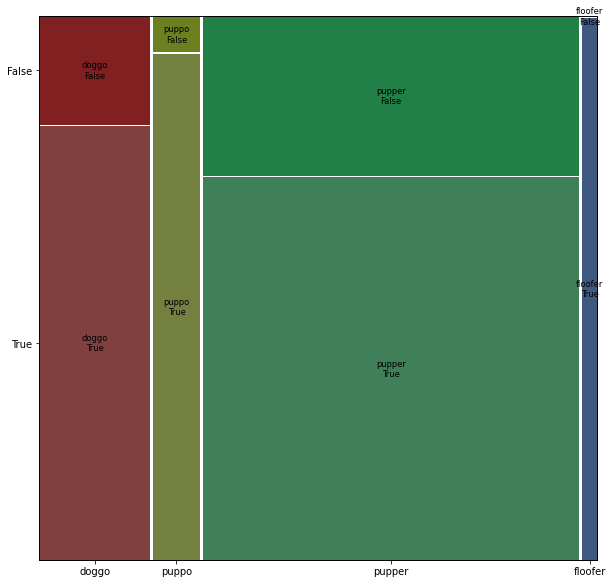

In [98]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 10
mosaic(df_tam, ['dog_state', 'is_prediction_1_dog_breed'])

(<Figure size 720x720 with 3 Axes>,
 OrderedDict([(('doggo', 'True'),
               (0.0, 0.0, 0.19817677368212444, 0.8258186995728524)),
              (('doggo', 'False'),
               (0.0,
                0.829140958709065,
                0.19817677368212444,
                0.1708590412909349)),
              (('puppo', 'True'),
               (0.20310288205650867,
                0.0,
                0.08493290300662473,
                0.9302325581395349)),
              (('puppo', 'False'),
               (0.20310288205650867,
                0.9335548172757474,
                0.08493290300662473,
                0.06644518272425247)),
              (('pupper', 'True'),
               (0.29296189343751766,
                0.0,
                0.673801030519223,
                0.7119126720455624)),
              (('pupper', 'False'),
               (0.29296189343751766,
                0.715234931181775,
                0.673801030519223,
                0.28476506881822494

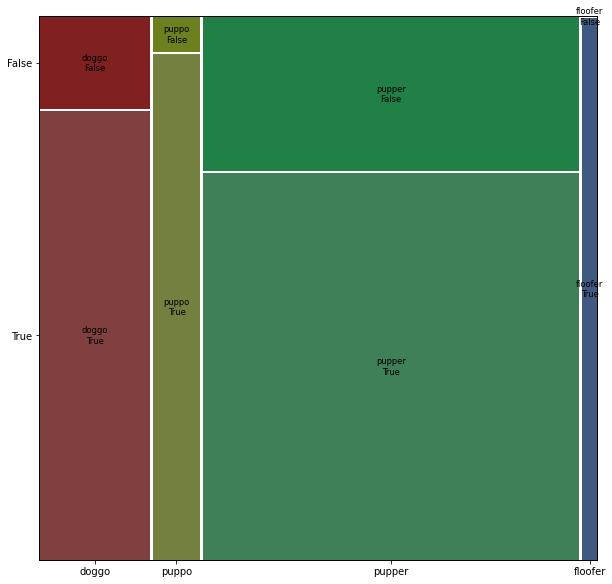

In [99]:
mosaic(df_tam, ['dog_state', 'is_prediction_2_dog_breed'])

(<Figure size 720x720 with 3 Axes>,
 OrderedDict([(('doggo', 'True'),
               (0.0, 0.0, 0.19817677368212444, 0.6834361651637398)),
              (('doggo', 'False'),
               (0.0,
                0.6867584242999525,
                0.19817677368212444,
                0.3132415757000474)),
              (('puppo', 'True'),
               (0.20310288205650867,
                0.0,
                0.08493290300662473,
                0.9966777408637874)),
              (('puppo', 'False'),
               (0.20310288205650867, 1.0, 0.08493290300662473, 0.0)),
              (('pupper', 'True'),
               (0.29296189343751766,
                0.0,
                0.673801030519223,
                0.6784108992434182)),
              (('pupper', 'False'),
               (0.29296189343751766,
                0.6817331583796309,
                0.673801030519223,
                0.31826684162036906)),
              (('floofer', 'True'),
               (0.9716890323311249,
 

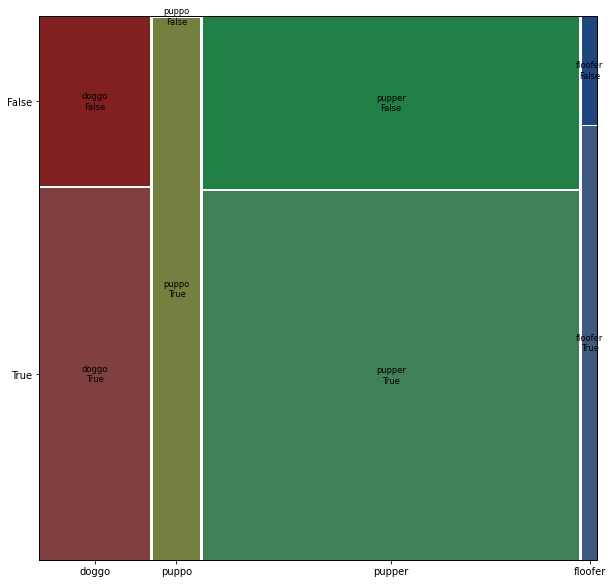

In [100]:
mosaic(df_tam, ['dog_state', 'is_prediction_3_dog_breed'])